# 3.2 DataLoaderの作成

- 本ファイルでは、PSPNetなどセマンティックセグメンテーション用のDatasetとDataLoaderを作成します。VOC2012データセットを対象とします。


# 学習目標

1.	セマンティックセグメンテーションで使用するDatasetクラス、DataLoaderクラスを作成できるようになる
2.	PSPNetの前処理およびデータオーギュメンテーションの処理内容を理解する

# 事前準備

- 書籍の指示に従い、本章で使用するデータをダウンロードします。


In [1]:
# パッケージのimport
import os.path as osp
from PIL import Image

import torch.utils.data as data
import matplotlib.pyplot as plt


# 画像データ、アノテーションデータへのファイルパスのリストを作成

In [2]:

def make_datapath_list(rootpath):
    """
    学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    # imgpath_template = osp.join(rootpath, '21gray_datasets', '%s.jpg') #ここ半角と全角のエラーがよく出るgray_cat_JPEGImages
    # annopath_template = osp.join(rootpath, '21anno_datasets_black', '%s.png')#cat_SegmentationClass_convert
    # imgpath_template = osp.join(rootpath, 'filament_taurus_datasets_grey', '%s.jpg') #ここ半角と全角のエラーがよく出るgray_cat_JPEGImages
    # annopath_template = osp.join(rootpath, 'filament_mask_convert', '%s.png')#cat_SegmentationClass_convert
        # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')
    
    
    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    # train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/21_train.txt')
    # val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/21_val.txt')
    # train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/taurus_train.txt')
    # val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/taurus_val.txt')
        # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [3]:
# #練習
# train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/cat_train.txt')
# val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/cat_val.txt')
# for line in open(train_id_names):
#   file_id = line.strip()
#   print(file_id)

In [4]:
# 動作確認 ファイルパスのリストを取得
rootpath = "../semantic_segmentation/data/VOCdevkit/VOC2012/"



# Datasetの作成

In [5]:
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
../semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


In [6]:
import sys

In [7]:
sys.path

['/home/filament/Downloads/semantic_segmentation',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/filament/.local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages']

In [8]:
sys.path.append('../3_semantic_segmentation/')

In [9]:
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

In [10]:
# データ処理のクラスとデータオーギュメンテーションのクラスをimportする



class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 画像の拡大
                RandomRotation(angle=[-10, 10]),  # 回転
                RandomMirror(),  # ランダムミラー
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ]),
            'val': Compose([
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)


In [11]:
class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとアノテーションを取得
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーションを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        print(image_file_path)
        img = Image.open(image_file_path)   # [高さ][幅][色RGB]
        print("オリジナル画像の型")
        print(type(img))

        # 2. アノテーション画像読み込み
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅]
        print("アノテーション画像の型")
        print(type(anno_class_img))
        # 3. 前処理を実施
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)
        print("self.transformを通した後の型")
        print(type(img),type(anno_class_img))

        return img, anno_class_img


In [12]:
# 動作確認

# (RGB)の色の平均値と標準偏差
# color_mean = (0.485, 0.456, 0.406)
# color_std = (0.229, 0.224, 0.225)
color_mean = 0.5
color_std = 0.2
# データセット作成
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# データの取り出し例
print(val_dataset.__getitem__(0)[0].shape)
print("------------------------------------------------")
print(val_dataset.__getitem__(0)[1].shape)
print("-------------------------------------------------")
print(val_dataset.__getitem__(0))


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 475, 475])
------------------------------------------------
../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([475, 475])
-------------------------------------------------
../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(tensor([[[ 1.8333,  1.6569,  1.7157,  ...,  1.9314,  1.8333,  1.8725],
         [ 1.7353,  1.5588,

In [13]:
#  for i in range(100): 
#   plt.imshow(val_dataset.__getitem__(i)[1])
#   plt.show()

In [14]:
# '/content/drive/MyDrive/3_semantic_segmentation/data/VOCdevkit/VOC2012/cat_JPEGImages/' =='/content/drive/MyDrive/3_semantic_segmentation/data/VOCdevkit/VOC2012/cat_JPEGImage/'

# DataLoaderを作成

In [16]:
# データローダーの作成

batch_size = 1

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
imges, anno_class_imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size())  # torch.Size([8, 3, 475, 475])


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 3, 475, 475])
torch.Size([1, 475, 475])


以上

# （付録）Datasetから画像を取り出し、描画する

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [18]:
from torchvision import transforms

## 訓練画像の描画

In [19]:
imges, anno_class_imges = train_dataset.__getitem__(0)

../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [20]:
type(imges)
img = transforms.functional.to_tensor(imges)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


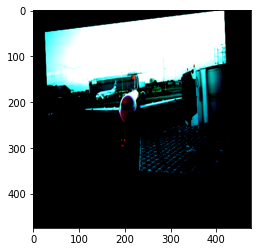

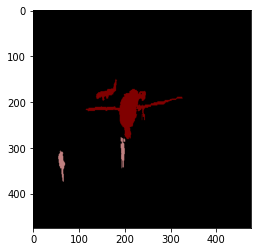

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


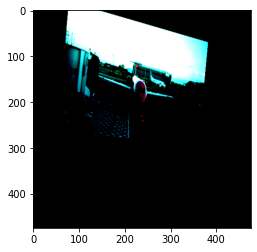

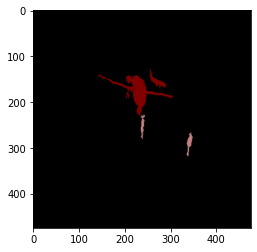

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


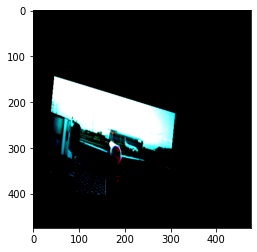

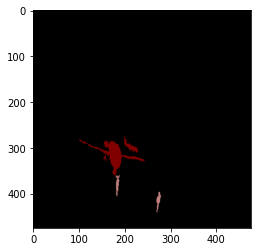

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


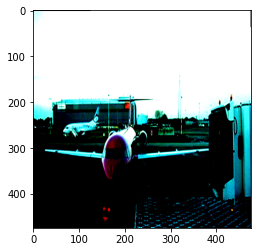

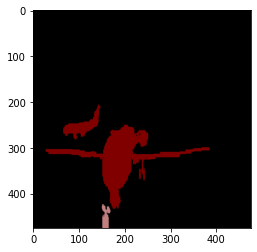

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


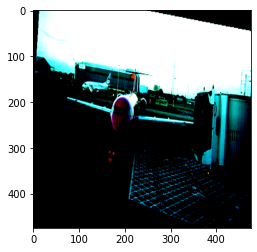

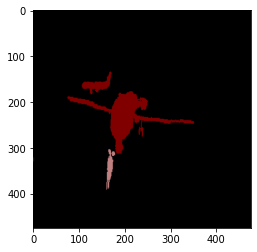

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


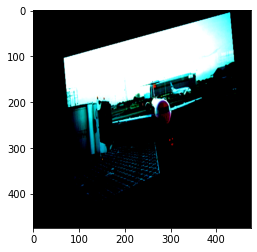

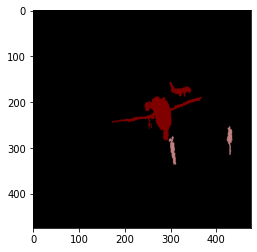

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


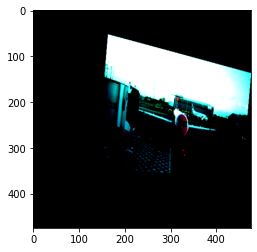

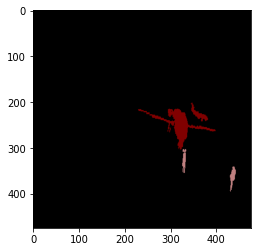

../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


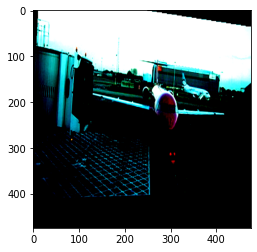

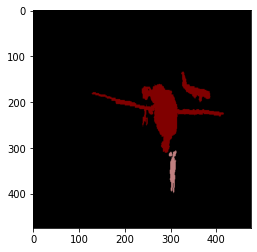

../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


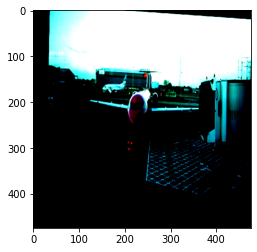

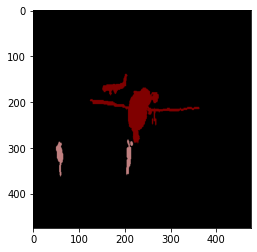

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


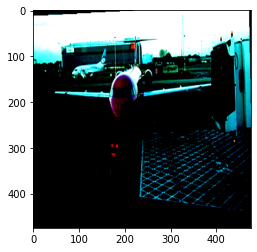

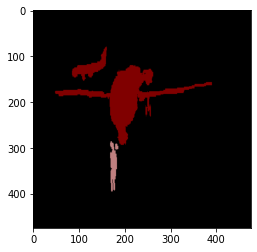

In [21]:

for i in range(10):

  # 実行するたびに変わります

  # 画像データの読み込み
  index = 0
  imges, anno_class_imges = train_dataset.__getitem__(index) #実行のたびにエラーが出る時と出ない時がある。
  # 画像の表示
  img_val = imges
  # img_val = transforms.functional.to_tensor(img_val)
  img_val = img_val.numpy().transpose((1, 2, 0))

  print(img_val.shape)
  plt.imshow(img_val.squeeze()) #１chだとimshow()できない？
  plt.show()

  # アノテーション画像の表示
  anno_file_path = train_anno_list[0]
  anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
  p_palette = anno_class_img.getpalette()
  # anno_class_imges = transforms.functional.to_tensor(anno_class_imges)
  anno_class_img_val = anno_class_imges.numpy()
  
  anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
  anno_class_img_val.putpalette(p_palette)
  plt.imshow(anno_class_img_val)
  plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


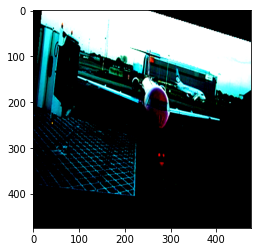

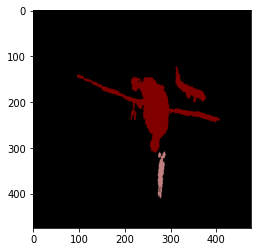

In [22]:



# 実行するたびに変わります

# 画像データの読み込み
index = 0
imges, anno_class_imges = train_dataset.__getitem__(index) #実行のたびにエラーが出る時と出ない時がある。
#data_augumentation.pyに問題があった
# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print(img_val.shape)
# plt.imshow(img_val.squeeze()) #１chだとimshow()できない？
plt.imshow(img_val.squeeze(),cmap='gray') #１chだとimshow()できない？
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()



オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 1)



オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>

In [23]:
neko = Image.open("../3_semantic_segmentation/data/VOCdevkit/VOC2012/gray_cat_JPEGImages/2010_001331.jpg")

FileNotFoundError: [Errno 2] No such file or directory: '../3_semantic_segmentation/data/VOCdevkit/VOC2012/gray_cat_JPEGImages/2010_001331.jpg'

## 検証画像の描画

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000123.jpg
オリジナル画像の型
<class 'PIL.JpegImagePlugin.JpegImageFile'>
アノテーション画像の型
<class 'PIL.PngImagePlugin.PngImageFile'>
self.transformを通した後の型
<class 'torch.Tensor'> <class 'torch.Tensor'>
(475, 475, 3)


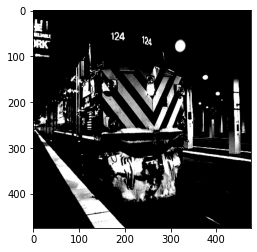

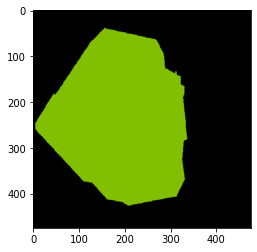

In [24]:
# 画像データの読み込み
index = 3
imges, anno_class_imges = val_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print(img_val.shape)
plt.imshow(img_val.squeeze(),cmap='gray')
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()


以上

In [ ]:
ssss